In [1]:
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, mean_squared_error
from pandas.plotting import scatter_matrix
import pickle


In [3]:
nlp_df = pd.read_csv('../data/df_with_nlp.csv', index_col=0)
X = nlp_df
# X = X[['culture-values-stars', 'career-opportunities-stars',
#                        'comp-benefit-stars', 'senior-management-stars', 'helpful-count',
#                        'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter', 'timesteps', 'incomplete_review', 'pros_len', 'cons_len']]
y = pd.read_csv("../data/work-balance-stars.csv", header=None, index_col=0).values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
X_train = X_train.reindex(sorted(X.columns), axis=1)
X_test = X_test.reindex(sorted(X.columns), axis=1)

In [16]:
def logcosh(true, pred):
    loss = np.log(np.cosh(pred - true))
    return np.mean(loss)

### Random Forest

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100, 200, 500, 1000],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)
print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 39.9min finished


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}


In [17]:
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

C:\Users\jq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [21]:
with open('models/random_forest_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(rf, f)

### Gradient Boosted Regressor

In [31]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, verbose=1, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [16]:
with open('models/gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(xgb_model, f)

In [6]:
param_grid = {'max_depth': [3],
              'learning_rate': [0.01],
              'n_estimators': [100, 200, 500, 1000],
              'subsample': [0.5]
              }

gbr_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                             param_grid,
                             n_jobs=-1,
                             verbose=1,
                             scoring='neg_mean_squared_error',
                             cv=3)
gbr_gridsearch.fit(X_train, y_train)
print( "best parameters:", gbr_gridsearch.best_params_ )

best_gbr_model = gbr_gridsearch.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.3min finished


best parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [32]:
best_y_preds = best_gbr_model.predict(X_test)

In [33]:
with open('models/best_gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(best_gbr_model, f)

### RNN

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint

In [28]:
with open('models/rnn_model.pkl', 'rb') as f:
    NN_model = pickle.load(f)

In [16]:
timesteps=1

In [29]:
X_train = X_train[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]
X_test = X_test[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]

In [9]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(64, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.2))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [22]:
NN_model.fit(X_train, y_train, epochs=5, batch_size=64, 
             validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=callbacks_list)

NameError: name 'callbacks_list' is not defined

In [15]:
with open('models/rnn_model.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(NN_model, f)

### Later

In [ ]:
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
_ = scatter_matrix(amazon_df, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:


fig, ax = plt.subplots(figsize=(14, 3))

plot_univariate_smooth(
    ax, 
    non_zero_bal_df["limit"].values.reshape(-1, 1),
    non_zero_bal_df['balance'],
    bootstrap=100)

ax.set_title("Univariate Effect of Credit Limit on Non-zero Bank Balance")
ax.set_ylabel("Non-zero Balance")
ax.set_xlabel("Limit")

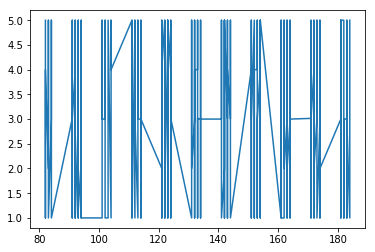

In [6]:
plt.plot(X['timesteps'], y)

In [ ]:
limit_fit = Pipeline([
    ('limit', ColumnSelector(name='limit')),
    ('limit_spline', LinearSpline(knots=[2500, 6000, 7000]))
])